In [2]:
import os

from tensorflow.python.keras.utils.np_utils import to_categorical

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
# mnist находится внутри keras, а он уже есть в tensorflow
from keras.datasets import mnist
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


In [3]:
# Загружаем обучающий и тестовый наборы с помощью функции load_data():
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Посмотрим, сколько загрузилось данных
print("В обучающей выборке образов x:", len(x_train), "целевых значений y:", len(y_train))
print("В тестовой выборке образов x:", len(x_test), "целевых значений y:", len(y_test))

В обучающей выборке образов x: 60000 целевых значений y: 60000
В тестовой выборке образов x: 10000 целевых значений y: 10000


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  57 241 196  60   0   0   6  18  18  79
  150 255 254 216  27   0   0   0   0   0]
 [  0   0   0   0   0   0   0  10 158 253 253 197 154 154 184 25

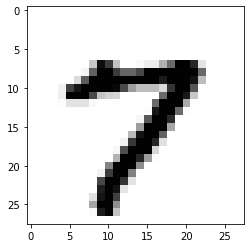

In [5]:
# Посмотрим, что внутри обучающих данных:
n1 = 5555  # выбрали номер от 0 до 60000
plt.imshow((255 - x_train[n1]), cmap="gray")
print(x_train[n1])

In [6]:
# приводим оттенки серого 0..255 к диапазону 0..1
x_train = x_train / 255
x_test = x_test / 255
print("Размер обучающих данных: ", tf.shape(x_train).numpy())

Размер обучающих данных:  [60000    28    28]


In [7]:
# выпрямляем массив, чтобы он сих квадратного превратился в линейный
# [-1, 28*28]  означает что, матрица 28 на 28 выпрямляется в массив размером
# 28*28 штук, а перзмерность по первой оси, где стоит -1 вычисляется
# автоматически
x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, 28 * 28])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, 28 * 28])
print("Новый размер: ", tf.shape(x_train).numpy())

Новый размер:  [60000   784]


In [8]:
# переделываем целевые значения
# y_train[i] -- это цифра, подлежащая различению, например 3
# Превратим её в массив [0 0 0 1 0 0 0 0 0 0]
# здесь 1 стоит на 3 месте. Это и есть целевые выходы
# нейронов последнего слоя, чтобы именно нейрон с номером 3
# откликался на изображение цифры 3
# Для такого преобразования есть специальная функция  to_categorical
# Такой формат называется вектор One-hot
print("Целевое значение до преобразования:", y_train[n1])

Целевое значение до преобразования: 7


In [9]:
y_train = to_categorical(y_train, 10)

In [10]:
print("Целевое значение после преобразования:", y_train[n1])


Целевое значение после преобразования: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [11]:
# Создаём модель слоя
class DenseNN(tf.Module):
    # Конструктор. Заполняет начальные значения
    def __init__(self, outputs, activate="relu"):
        super().__init__()
        self.outputs = outputs  # количество выходов = количеству нейронов в слое
        self.activate = activate  # тип активационной функции (по умолчанию relu)
        self.fl_init = False  # становится true после первой инициализации весов

    # Функция для расчёта выходных величин сети
    def __call__(self, x):
        if not self.fl_init:  # если весов ещё нет, создаём их случайными
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w")
            self.b = tf.zeros([self.outputs], dtype=tf.float32, name="b")
            # Размер тензора w: (x.shape[-1], self.outputs)
            # здесь x.shape[-1] - размер вектора входных данных,
            # то есть, сколько входов в первый раз подпдим на сеть,
            # столько весов к каждому нейрону и сформируется
            # следовательно, первый индекс - номер входа нейрона
            # второй размер self.outputs совпадает с кличеством выходов
            # и с количествот нейронов в слое, значит второй
            # индекс - номер нейрона
            # stddev=0.1 - среднеквадратическое отклонение

            # преобразуем w и b в тензоры
            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b)

            self.fl_init = True
        # матричное вычисление выхода слоя
        y = x @ self.w + self.b

        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "softmax":
            return tf.nn.softmax(y)

        return y


In [12]:
# создадим два полносвязных слоя со 128 нейронами и 10
layer_1 = DenseNN(128)
layer_2 = DenseNN(10, activate="softmax")


In [13]:
# Функция расчёта значений на выходе сети
def model_predict(x):
    y = layer_1(x)
    y = layer_2(y)
    return y  # layer_2(layer_1(x))


In [14]:
# Задание функции потерь
cross_entropy = lambda y_true, y_pred: tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))
# y_true, y_pred – это наборы one-hot векторов размером мини-батча


In [15]:
# определим оптимизатор для градиентного спуска
opt = tf.optimizers.Adam(learning_rate=0.001)
# opt = tf.optimizers.SGD(learning_rate=0.02)
# opt = tf.optimizers.SGD(momentum=0.5, learning_rate=0.02)  # Метод моментов
# opt = tf.optimizers.SGD(momentum=0.5, nesterov=True, learning_rate=0.02) # Метод Нестерова
# opt = tf.optimizers.Adagrad(learning_rate=0.1) # Adagrad
# opt = tf.optimizers.Adadelta(learning_rate=1.0)  # Adadelta
# opt = tf.optimizers.RMSprop(learning_rate=0.01)
# opt = tf.optimizers.Adam(learning_rate=0.1)

In [16]:
# Готовим обучение
BATCH_SIZE = 32
EPOCHS = 10
TOTAL = x_train.shape[0]
print(TOTAL)  # Количество штук в обучающей выборке

60000


In [17]:
# tf.data.Dataset - это класс с набором обучающих данных.
# Его можно создать из списков питона методом from_tensor_slices
# можно из файлов dataset = tf.data.TextLineDataset(["file1.txt", "file2.txt"])
# подробнее https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Перемешиваем выборкии разбиваеи на батчи
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [18]:
print(train_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [19]:
# Цикл обучения
for n in range(EPOCHS):
    loss = 0
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            f_loss = cross_entropy(y_batch, model_predict(x_batch))

        loss += f_loss
        grads = tape.gradient(f_loss, [layer_1.trainable_variables, layer_2.trainable_variables])
        opt.apply_gradients(zip(grads[0], layer_1.trainable_variables))
        opt.apply_gradients(zip(grads[1], layer_2.trainable_variables))

    print(loss.numpy())

462.75034
194.3775
134.64606
100.473114
75.28524
60.186634
45.200104
35.932014
27.658915
23.74391


In [20]:
y = model_predict(x_test)
y2 = tf.argmax(y, axis=1).numpy()
acc = len(y_test[y_test == y2]) / y_test.shape[0] * 100
print(acc)

97.72
